In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [224]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

In [225]:
pd.get_dummies(baseline_harmonized, columns=[treatment_col] + discrete_cov).groupby(
    by=["project"]
).mean()

,age,hcows,edu,hwithdraw,alcdisorder,cocdisorder,hasBrainDamage,hasEpilepsy,hasSchiz,hasBipolar,...,medicine_assigned_nal,xrace_1,xrace_2,xrace_3,xrace_4,mar_1.0,mar_2.0,mar_3.0,sex_female,sex_male
project,,,,,,,,,,,,,,,,,,,,,
27,36.881196,12.789223,2.085890,2.473059,0.212903,0.323102,0.091483,0.031471,0.025217,0.115748,...,0.000000,0.675846,0.085759,0.162077,0.076318,0.020456,0.037766,0.069237,0.322581,0.677419
30,32.058333,13.041899,2.227778,2.469274,0.108333,0.077778,0.175000,0.025000,0.002793,0.058496,...,0.000000,0.886111,0.022222,0.050000,0.041667,0.283333,0.213889,0.500000,0.419444,0.580556
51,33.857895,16.677193,2.168421,2.877193,0.278947,0.307018,0.121053,0.085965,0.012281,0.138596,...,0.496491,0.652632,0.094737,0.173684,0.078947,0.096491,0.215789,0.687719,0.296491,0.703509


## TEDS-A vs CTN 27

In [226]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_met"] = (
    (ct94[treatment_col] == "met").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")

ct94_cc.groupby(by="med_met").mean()[outcome_cols]

,opioiduse12,opioiduse24
med_met,,
0,0.629380,0.750674
1,0.553875,0.650284


In [391]:
print(
    (
        100
        * (
            ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].mean()
            - ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].mean()
        ),
        1.96
        * 100
        * np.sqrt(
            ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].var()
            / ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].shape[0]
            + ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].var()
            / ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].shape[0]
        ),
    )
)

(-10.03903005722031, 5.123408063788226)


In [297]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=0.05), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace", "mar"])
data_dummy["Education(12y)"] = (data_dummy["edu"] >= 2).astype(int)
data_dummy.drop(columns=["edu", "mar_0"], inplace=True)
data_dummy.rename(
    columns={
        "sex": "Sex",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        "mar_1": "Married",
        "mar_2": "Divorced/Separated",
        "mar_3": "Single",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

In [298]:
X.shape

(38272, 14)

In [386]:
importlib.reload(learn)
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, data2 = learn.estimate_dml(
    data_dummy, outcome, treatment, sample, crossfit=3
)

Fold 0
Fold 1
Fold 2


In [393]:
print(df_v.join(S).groupby(by="S").mean())
print(df_v.join(S).mean()["te"] * 100)
print(np.sqrt(df_v.join(S).mean()["te_sq"] / df_v.shape[0]) * 100)

         te     te_sq
S                    
1 -0.003122  4.981102
-0.312249545474516
6.260225281579554


In [395]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=1,
    num_trees=3000,
    vote_threshold=1 / 2,
    # top_k_trees=True,
    # k=50,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
print("Baseline Objective:%.4f" % (baseline_loss))

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
ATE Est: -0.0037
leaf                  0.500000
IV Drug Use           0.000727
Sex                   0.015431
Age                   0.000293
Hx Cannabis           0.007862
Hx Benzo              0.016777
Hx Amphetamine        0.005213
White                 0.016243
Black                 0.051584
Hispanic              0.012826
Other Race            0.022515
Married               0.054721
Divorced/Separated    0.055343
Single                0.103591
Education(12y)        0.136874
dtype: float64
Baseline Objective:0.0683


Number of Selected Trees: 1422


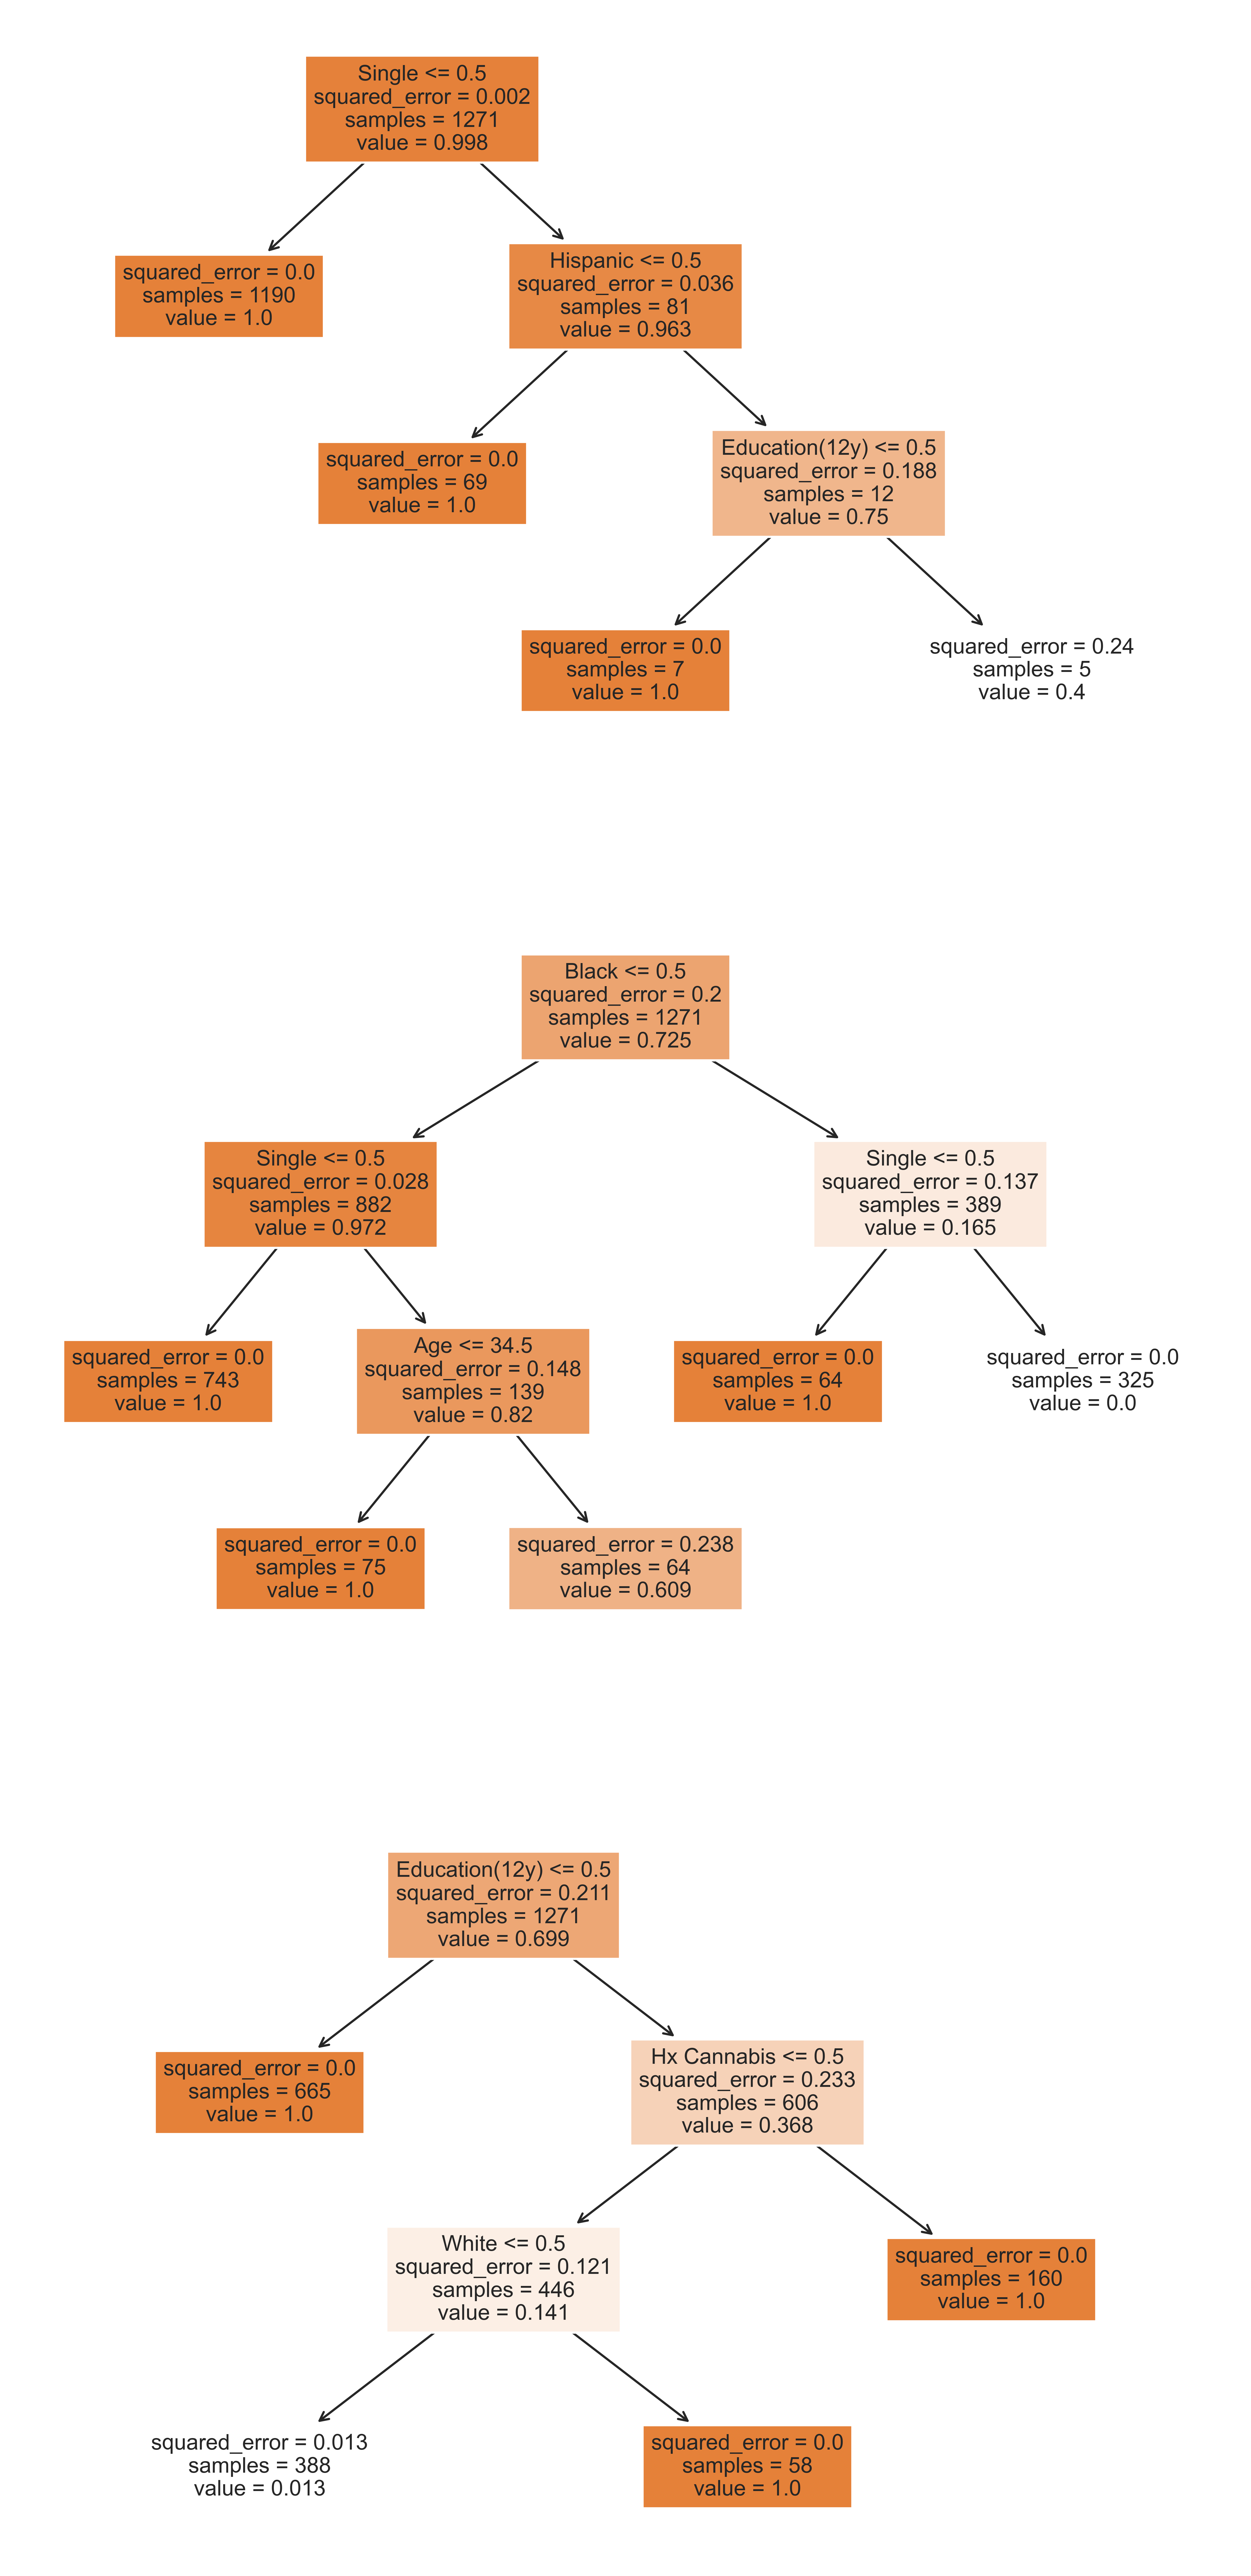

In [400]:
w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if w_forest[i]["local objective"] < baseline_loss
]
print("Number of Selected Trees: %d" % (len(w_rash)))
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.25).astype(int)

explainer = en.AdaBoostRegressor().fit(X.loc[avg_votes.index], avg_votes)

len(explainer.estimators_)

num_trees = min(3, len(explainer.estimators_))
fig, ax = plt.subplots(nrows=num_trees, figsize=(10, 7 * num_trees), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer.estimators_[i],
            feature_names=X.columns,
            ax=ax,
            filled=True,
            fontsize=10,
            # proportion=True,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i],
            feature_names=X.columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            # proportion=True,
        )
plt.savefig("tedsa_ctn27_2.pdf", dpi=600)

In [384]:
X.join(S).join(D_forest[["v", "vsq", "l(X)"]]).groupby(
    by=["Black", "IV Drug Use", "Sex"]
).mean()[
    ["v", "vsq", "l(X)"]
]  # .sort_values(by="l(X)", ascending=False)

v       vsq      l(X)
Black IV Drug Use Sex                              
0     0           0   -0.054668  0.172890  0.295995
                  1    0.037702  0.280574  0.460871
      1           0   -0.206107  0.179970  0.787740
                  1   -0.127103  0.243849  1.467601
1     0           0   -0.031496  0.119865  0.061230
                  1    0.006661  0.080324  0.122885
      1           0   -0.177581  4.646773  0.270809
                  1   -0.081737  0.160134  0.665295

In [383]:
(
    X.join(D_forest[["v", "vsq", "l(X)", "S"]])
    .loc[D_forest["S"] == 0]
    .groupby(by=["Black", "IV Drug Use", "Sex"])
    .count()[["v", "vsq", "l(X)"]]
    / (X.join(D_forest[["v", "vsq", "l(X)", "S"]]).loc[D_forest["S"] == 0].shape[0])
).round(2) / (
    X.join(D_forest[["v", "vsq", "l(X)", "S"]])
    .loc[D_forest["S"] == 1]
    .groupby(by=["Black", "IV Drug Use", "Sex"])
    .count()[["v", "vsq", "l(X)"]]
    / (X.join(D_forest[["v", "vsq", "l(X)", "S"]]).loc[D_forest["S"] == 1].shape[0])
).round(
    2
)

v       vsq      l(X)
Black IV Drug Use Sex                              
0     0           0    1.600000  1.600000  1.600000
                  1    1.176471  1.176471  1.176471
      1           0    1.000000  1.000000  1.000000
                  1    0.666667  0.666667  0.666667
1     0           0    5.000000  5.000000  5.000000
                  1    3.000000  3.000000  3.000000
      1           0    2.000000  2.000000  2.000000
                  1    0.750000  0.750000  0.750000

In [380]:
(
    X.join(D_forest[["v", "vsq", "l(X)", "S"]])
    .loc[D_forest["S"] == 0]
    .groupby(by=["Black", "IV Drug Use", "Sex"])
    .count()[["v", "vsq", "l(X)"]]
    / (X.join(D_forest[["v", "vsq", "l(X)", "S"]]).loc[D_forest["S"] == 0].shape[0])
).round(2)

v   vsq  l(X)
Black IV Drug Use Sex                  
0     0           0    0.16  0.16  0.16
                  1    0.20  0.20  0.20
      1           0    0.20  0.20  0.20
                  1    0.30  0.30  0.30
1     0           0    0.05  0.05  0.05
                  1    0.06  0.06  0.06
      1           0    0.02  0.02  0.02
                  1    0.03  0.03  0.03

In [317]:
print(
    r"Pre Pruning, SATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * 1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)

print(
    r"Pre Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].mean(),
        100 * 1.96 * np.sqrt(D_rash["vsq"].mean() / D_rash["w_opt"].count()),
    )
)

print(
    r"Post Pruning, ATTE: %.2f ± %.2f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        100
        * 1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].mean() / D_rash["w_opt"].sum()
        ),
    )
)

Pre Pruning, SATE: -10.04 ± 7.18
Pre Pruning, ATTE: -8.64 ± 0.53
Post Pruning, ATTE: -8.97 ± 0.50


In [346]:
selection_score = lm.LogisticRegressionCV().fit(X, S)

In [365]:
pop_interest = (X["Black"] == 0) * (X["IV Drug Use"] == 0)  # * (X["Sex"] == 0)
X_interest = X.loc[pop_interest]
S_interest = S.loc[pop_interest]

In [366]:
(
    np.mean(
        selection_score.predict_proba(X_interest)[:, 1]
        / selection_score.predict_proba(X_interest)[:, 0]
    ),
    S_interest.mean() / (1 - S_interest.mean()),
)

(0.3873306196626835, 0.025555471297489953)

Thoughts:
* TEDSA (observational data) has fewer covariates than experimental sample. Maybe there is different and interesting question here?

In [358]:
pop_interest

3065250    False
4694296    False
4763008    False
5206960    False
4741349    False
           ...  
1933       False
1934       False
1935       False
1936       False
1937       False
Length: 38272, dtype: bool